# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [2]:
df = pd.read_csv("mammographic_masses.data.txt",
                 na_values="?",
                 names=("bi_rads", "age", "shape", "margin", "density", "severity"))
df.head()

,bi_rads,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [3]:
df.describe()


,bi_rads,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [4]:
df_nulls = df.isnull().astype(int)
df_nulls.corr()

,bi_rads,age,shape,margin,density,severity
bi_rads,1.000000,-0.003303,0.120896,0.094349,-0.013383,NaN
age,-0.003303,1.000000,-0.013204,-0.016582,-0.021193,NaN
shape,0.120896,-0.013204,1.000000,0.228499,0.033791,NaN
margin,0.094349,-0.016582,0.228499,1.000000,0.216018,NaN
density,-0.013383,-0.021193,0.033791,0.216018,1.000000,NaN
severity,NaN,NaN,NaN,NaN,NaN,NaN


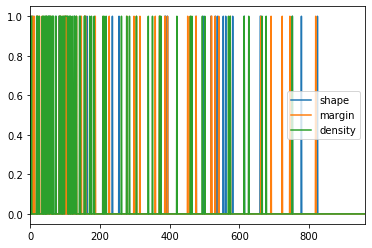

In [5]:
axes = plt.gca()
df_nulls.plot(kind="line", y="shape",ax=axes)
df_nulls.plot(kind="line", y="margin",ax=axes)
df_nulls.plot(kind="line", y="density",ax=axes)

plt.show()

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [6]:
print(df.shape)
df_cleaned = df.dropna()
print(df_cleaned.shape)

(961, 6)
(830, 6)


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [7]:
# features
df_features = df_cleaned[["age", "shape", "margin", "density"]]
feature_names = df_features.columns.to_numpy()
features = df_features.to_numpy()
classes = df_cleaned["severity"].to_numpy()

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [8]:
scaler = StandardScaler()
scaler.fit(features)
#print(scaler.mean_)
scaled_features = scaler.transform(features)
#print(scaled_features[:5])
#print(features[:5])

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [9]:
mask = np.random.rand(len(classes)) < 0.75
x_train, x_test = scaled_features[mask], scaled_features[~mask]
y_train, y_test = classes[mask], classes[~mask]
print(len(x_train))
print(len(x_test))

611
219


Now create a DecisionTreeClassifier and fit it to your training data.

In [10]:
dt_classifier = tree.DecisionTreeClassifier()
dt_classifier = dt_classifier.fit(x_train, y_train)

Display the resulting decision tree.

[Text(129.07510728433098, 211.7178947368421, 'X[2] <= -0.838\ngini = 0.499\nsamples = 611\nvalue = [322, 289]'),
 Text(61.37508802816901, 200.2736842105263, 'X[0] <= 0.595\ngini = 0.206\nsamples = 240\nvalue = [212, 28]'),
 Text(29.61919014084507, 188.82947368421054, 'X[0] <= -1.11\ngini = 0.156\nsamples = 211\nvalue = [193, 18]'),
 Text(4.715492957746479, 177.38526315789474, 'X[0] <= -1.451\ngini = 0.03\nsamples = 66\nvalue = [65, 1]'),
 Text(2.3577464788732394, 165.94105263157894, 'gini = 0.0\nsamples = 43\nvalue = [43, 0]'),
 Text(7.073239436619718, 165.94105263157894, 'X[0] <= -1.383\ngini = 0.083\nsamples = 23\nvalue = [22, 1]'),
 Text(4.715492957746479, 154.49684210526317, 'X[1] <= -1.032\ngini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(2.3577464788732394, 143.05263157894737, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(7.073239436619718, 143.05263157894737, 'X[3] <= -1.185\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(4.715492957746479, 131.60842105263157, 'gini = 

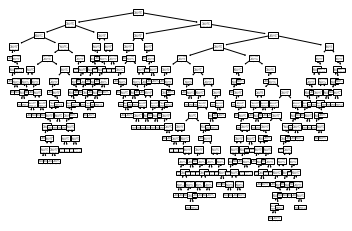

In [11]:
tree.plot_tree(dt_classifier)

Measure the accuracy of the resulting decision tree model using your test data.

In [12]:
predicted = dt_classifier.predict(x_test)
# accuracy_score(y_test, predicted)
dt_classifier.score(x_test, y_test)

0.7397260273972602

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [13]:

scores = cross_val_score(dt_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

[0.71428571 0.78571429 0.77380952 0.73493976 0.77108434 0.6746988
 0.72289157 0.76829268 0.75609756 0.69512195]
0.7396936176762801


Now try a RandomForestClassifier instead. Does it perform better?

In [14]:
rf_classifier = RandomForestClassifier(n_estimators=10)
rf_classifier = rf_classifier.fit(x_train, y_train)
print(rf_classifier.score(x_test, y_test))

scores = cross_val_score(rf_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.7945205479452054
[0.73809524 0.79761905 0.80952381 0.78313253 0.79518072 0.71084337
 0.75903614 0.75609756 0.79268293 0.69512195]
0.7637333305346823


## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [15]:
sv_classifier = SVC(kernel="linear")
sv_classifier = sv_classifier.fit(x_train, y_train)
print(sv_classifier.score(x_test, y_test))

scores = cross_val_score(sv_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.8036529680365296
[0.71428571 0.77380952 0.86904762 0.80722892 0.84337349 0.69879518
 0.80722892 0.80487805 0.90243902 0.74390244]
0.7964988875362076


## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [16]:
knn = KNeighborsClassifier(n_neighbors=10)
knn = knn.fit(x_train, y_train)
print(knn.score(x_test, y_test))

scores = cross_val_score(knn, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.7990867579908676
[0.77380952 0.76190476 0.83333333 0.74698795 0.87951807 0.72289157
 0.81927711 0.79268293 0.81707317 0.70731707]
0.7854795488574507


Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [17]:
knn_runs = []
for i in range(50):
    n = i+1
    mean_score = cross_val_score(KNeighborsClassifier(n_neighbors=n), scaled_features, classes, cv=10).mean()
    knn_runs.append((mean_score, n))
knn_runs.sort(key=lambda x: x[0], reverse=True)
knn_runs[:10]

[(0.7940595133145824, 7),
 (0.7927235072694961, 50),
 (0.7915333809104012, 11),
 (0.7915039950743742, 14),
 (0.7914172368918182, 31),
 (0.7902995256286471, 49),
 (0.7902271105327232, 28),
 (0.7890653205155116, 48),
 (0.7880200243482641, 9),
 (0.7878891874116676, 39)]

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [18]:
minmax_features = MinMaxScaler().fit_transform(features) # scale between 0 and 1 preserving shape of data
nb_classifier = MultinomialNB()
nb_classifier.fit(minmax_features[mask], classes[mask])
print(nb_classifier.score(minmax_features[~mask], classes[~mask]))

scores = cross_val_score(nb_classifier, minmax_features, classes, cv=10)
print(scores)
print(scores.mean())

0.7990867579908676
[0.73809524 0.76190476 0.82142857 0.8313253  0.8313253  0.73493976
 0.74698795 0.76829268 0.91463415 0.69512195]
0.7844055665169388


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [19]:
svrbf_classifier = SVC(kernel="rbf", gamma="auto")
svrbf_classifier = svrbf_classifier.fit(x_train, y_train)
print(svrbf_classifier.score(x_test, y_test))

scores = cross_val_score(svrbf_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.8127853881278538
[0.75       0.79761905 0.86904762 0.80722892 0.86746988 0.72289157
 0.78313253 0.7804878  0.86585366 0.76829268]
0.8012023704574396


In [20]:
svsig_classifier = SVC(kernel="sigmoid", gamma="auto")
svsig_classifier = svsig_classifier.fit(x_train, y_train)
print(svsig_classifier.score(x_test, y_test))

scores = cross_val_score(svsig_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.7397260273972602
[0.70238095 0.67857143 0.76190476 0.72289157 0.74698795 0.71084337
 0.74698795 0.7804878  0.70731707 0.79268293]
0.7351055791108685


In [21]:
svpoly_classifier = SVC(kernel="poly", gamma="auto")
svpoly_classifier = svpoly_classifier.fit(x_train, y_train)
print(svpoly_classifier.score(x_test, y_test))

scores = cross_val_score(svpoly_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.8264840182648402
[0.76190476 0.77380952 0.88095238 0.79518072 0.84337349 0.69879518
 0.77108434 0.79268293 0.86585366 0.74390244]
0.792753942599667


## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [22]:
lbfgs_classifier = LogisticRegression(solver="lbfgs")
lbfgs_classifier = lbfgs_classifier.fit(x_train, y_train)
print(lbfgs_classifier.score(x_test, y_test))

scores = cross_val_score(lbfgs_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.8127853881278538
[0.76190476 0.76190476 0.88095238 0.81927711 0.8313253  0.71084337
 0.79518072 0.82926829 0.8902439  0.79268293]
0.8073583532737221


In [23]:
sag_classifier = LogisticRegression(solver="sag")
sag_classifier = sag_classifier.fit(x_train, y_train)
print(sag_classifier.score(x_test, y_test))

scores = cross_val_score(sag_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.8127853881278538
[0.76190476 0.76190476 0.88095238 0.81927711 0.8313253  0.71084337
 0.79518072 0.82926829 0.8902439  0.79268293]
0.8073583532737221


In [24]:
ll_classifier = LogisticRegression(solver="liblinear")
ll_classifier = ll_classifier.fit(x_train, y_train)
print(ll_classifier.score(x_test, y_test))

scores = cross_val_score(ll_classifier, scaled_features, classes, cv=10)
print(scores)
print(scores.mean())

0.8127853881278538
[0.76190476 0.76190476 0.88095238 0.81927711 0.8313253  0.71084337
 0.79518072 0.82926829 0.8902439  0.79268293]
0.8073583532737221


## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [31]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=4, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=150, verbose=2, batch_size=20)
scores = cross_val_score(estimator, scaled_features, classes, cv=10)
print(scores.mean())

Train on 747 samples
Epoch 1/150
747/747 - 1s - loss: 0.6470 - accuracy: 0.6158
Epoch 2/150
747/747 - 0s - loss: 0.6077 - accuracy: 0.7015
Epoch 3/150
747/747 - 0s - loss: 0.5772 - accuracy: 0.7323
Epoch 4/150
747/747 - 0s - loss: 0.5478 - accuracy: 0.7537
Epoch 5/150
747/747 - 0s - loss: 0.4986 - accuracy: 0.7898
Epoch 6/150
747/747 - 0s - loss: 0.5055 - accuracy: 0.7858
Epoch 7/150
747/747 - 0s - loss: 0.5031 - accuracy: 0.7724
Epoch 8/150
747/747 - 0s - loss: 0.4828 - accuracy: 0.7898
Epoch 9/150
747/747 - 0s - loss: 0.4737 - accuracy: 0.7831
Epoch 10/150
747/747 - 0s - loss: 0.4764 - accuracy: 0.7831
Epoch 11/150
747/747 - 0s - loss: 0.4880 - accuracy: 0.7845
Epoch 12/150
747/747 - 0s - loss: 0.4796 - accuracy: 0.7805
Epoch 13/150
747/747 - 0s - loss: 0.4741 - accuracy: 0.7965
Epoch 14/150
747/747 - 0s - loss: 0.4718 - accuracy: 0.7885
Epoch 15/150
747/747 - 0s - loss: 0.4658 - accuracy: 0.8046
Epoch 16/150
747/747 - 0s - loss: 0.4731 - accuracy: 0.7965
Epoch 17/150
747/747 - 0s - 

Epoch 137/150
747/747 - 0s - loss: 0.4323 - accuracy: 0.8059
Epoch 138/150
747/747 - 0s - loss: 0.4292 - accuracy: 0.8179
Epoch 139/150
747/747 - 0s - loss: 0.4369 - accuracy: 0.8139
Epoch 140/150
747/747 - 0s - loss: 0.4398 - accuracy: 0.8059
Epoch 141/150
747/747 - 0s - loss: 0.4328 - accuracy: 0.8086
Epoch 142/150
747/747 - 0s - loss: 0.4317 - accuracy: 0.8126
Epoch 143/150
747/747 - 0s - loss: 0.4327 - accuracy: 0.8032
Epoch 144/150
747/747 - 0s - loss: 0.4370 - accuracy: 0.8153
Epoch 145/150
747/747 - 0s - loss: 0.4331 - accuracy: 0.8153
Epoch 146/150
747/747 - 0s - loss: 0.4262 - accuracy: 0.8246
Epoch 147/150
747/747 - 0s - loss: 0.4403 - accuracy: 0.8032
Epoch 148/150
747/747 - 0s - loss: 0.4312 - accuracy: 0.8153
Epoch 149/150
747/747 - 0s - loss: 0.4346 - accuracy: 0.8112
Epoch 150/150
747/747 - 0s - loss: 0.4369 - accuracy: 0.8086
83/1 - 0s - loss: 0.4283 - accuracy: 0.7349
Train on 747 samples
Epoch 1/150
747/747 - 1s - loss: 0.7011 - accuracy: 0.5823
Epoch 2/150
747/747 - 

747/747 - 0s - loss: 0.4484 - accuracy: 0.8086
Epoch 123/150
747/747 - 0s - loss: 0.4459 - accuracy: 0.8059
Epoch 124/150
747/747 - 0s - loss: 0.4374 - accuracy: 0.8153
Epoch 125/150
747/747 - 0s - loss: 0.4407 - accuracy: 0.8059
Epoch 126/150
747/747 - 0s - loss: 0.4472 - accuracy: 0.8126
Epoch 127/150
747/747 - 0s - loss: 0.4396 - accuracy: 0.8072
Epoch 128/150
747/747 - 0s - loss: 0.4430 - accuracy: 0.8086
Epoch 129/150
747/747 - 0s - loss: 0.4565 - accuracy: 0.8019
Epoch 130/150
747/747 - 0s - loss: 0.4402 - accuracy: 0.8086
Epoch 131/150
747/747 - 0s - loss: 0.4425 - accuracy: 0.8166
Epoch 132/150
747/747 - 0s - loss: 0.4496 - accuracy: 0.8166
Epoch 133/150
747/747 - 0s - loss: 0.4499 - accuracy: 0.8032
Epoch 134/150
747/747 - 0s - loss: 0.4446 - accuracy: 0.8139
Epoch 135/150
747/747 - 0s - loss: 0.4438 - accuracy: 0.8086
Epoch 136/150
747/747 - 0s - loss: 0.4469 - accuracy: 0.8193
Epoch 137/150
747/747 - 0s - loss: 0.4516 - accuracy: 0.8059
Epoch 138/150
747/747 - 0s - loss: 0.4

Epoch 108/150
747/747 - 0s - loss: 0.4656 - accuracy: 0.7952
Epoch 109/150
747/747 - 0s - loss: 0.4697 - accuracy: 0.8086
Epoch 110/150
747/747 - 0s - loss: 0.4680 - accuracy: 0.8005
Epoch 111/150
747/747 - 0s - loss: 0.4702 - accuracy: 0.8019
Epoch 112/150
747/747 - 0s - loss: 0.4605 - accuracy: 0.8086
Epoch 113/150
747/747 - 0s - loss: 0.4635 - accuracy: 0.7992
Epoch 114/150
747/747 - 0s - loss: 0.4640 - accuracy: 0.8072
Epoch 115/150
747/747 - 0s - loss: 0.4523 - accuracy: 0.8032
Epoch 116/150
747/747 - 0s - loss: 0.4527 - accuracy: 0.8112
Epoch 117/150
747/747 - 0s - loss: 0.4613 - accuracy: 0.8046
Epoch 118/150
747/747 - 0s - loss: 0.4613 - accuracy: 0.7992
Epoch 119/150
747/747 - 0s - loss: 0.4577 - accuracy: 0.7938
Epoch 120/150
747/747 - 0s - loss: 0.4573 - accuracy: 0.8032
Epoch 121/150
747/747 - 0s - loss: 0.4537 - accuracy: 0.8153
Epoch 122/150
747/747 - 0s - loss: 0.4528 - accuracy: 0.8086
Epoch 123/150
747/747 - 0s - loss: 0.4632 - accuracy: 0.8099
Epoch 124/150
747/747 - 

Epoch 93/150
747/747 - 0s - loss: 0.4558 - accuracy: 0.7965
Epoch 94/150
747/747 - 0s - loss: 0.4460 - accuracy: 0.8032
Epoch 95/150
747/747 - 0s - loss: 0.4504 - accuracy: 0.8032
Epoch 96/150
747/747 - 0s - loss: 0.4524 - accuracy: 0.7938
Epoch 97/150
747/747 - 0s - loss: 0.4538 - accuracy: 0.8046
Epoch 98/150
747/747 - 0s - loss: 0.4588 - accuracy: 0.7952
Epoch 99/150
747/747 - 0s - loss: 0.4620 - accuracy: 0.8005
Epoch 100/150
747/747 - 0s - loss: 0.4548 - accuracy: 0.8005
Epoch 101/150
747/747 - 0s - loss: 0.4640 - accuracy: 0.8032
Epoch 102/150
747/747 - 0s - loss: 0.4671 - accuracy: 0.8032
Epoch 103/150
747/747 - 0s - loss: 0.4522 - accuracy: 0.7965
Epoch 104/150
747/747 - 0s - loss: 0.4540 - accuracy: 0.8086
Epoch 105/150
747/747 - 0s - loss: 0.4578 - accuracy: 0.8099
Epoch 106/150
747/747 - 0s - loss: 0.4590 - accuracy: 0.8112
Epoch 107/150
747/747 - 0s - loss: 0.4574 - accuracy: 0.8112
Epoch 108/150
747/747 - 0s - loss: 0.4602 - accuracy: 0.8046
Epoch 109/150
747/747 - 0s - lo

Epoch 78/150
747/747 - 0s - loss: 0.4627 - accuracy: 0.8032
Epoch 79/150
747/747 - 0s - loss: 0.4756 - accuracy: 0.7871
Epoch 80/150
747/747 - 0s - loss: 0.4686 - accuracy: 0.7965
Epoch 81/150
747/747 - 0s - loss: 0.4554 - accuracy: 0.8166
Epoch 82/150
747/747 - 0s - loss: 0.4638 - accuracy: 0.7938
Epoch 83/150
747/747 - 0s - loss: 0.4560 - accuracy: 0.8005
Epoch 84/150
747/747 - 0s - loss: 0.4634 - accuracy: 0.8072
Epoch 85/150
747/747 - 0s - loss: 0.4647 - accuracy: 0.8032
Epoch 86/150
747/747 - 0s - loss: 0.4598 - accuracy: 0.7979
Epoch 87/150
747/747 - 0s - loss: 0.4729 - accuracy: 0.7898
Epoch 88/150
747/747 - 0s - loss: 0.4615 - accuracy: 0.7925
Epoch 89/150
747/747 - 0s - loss: 0.4620 - accuracy: 0.7952
Epoch 90/150
747/747 - 0s - loss: 0.4722 - accuracy: 0.7965
Epoch 91/150
747/747 - 0s - loss: 0.4556 - accuracy: 0.8086
Epoch 92/150
747/747 - 0s - loss: 0.4630 - accuracy: 0.8032
Epoch 93/150
747/747 - 0s - loss: 0.4680 - accuracy: 0.7965
Epoch 94/150
747/747 - 0s - loss: 0.4646

Epoch 63/150
747/747 - 0s - loss: 0.4438 - accuracy: 0.8166
Epoch 64/150
747/747 - 0s - loss: 0.4566 - accuracy: 0.8139
Epoch 65/150
747/747 - 0s - loss: 0.4579 - accuracy: 0.8099
Epoch 66/150
747/747 - 0s - loss: 0.4456 - accuracy: 0.8072
Epoch 67/150
747/747 - 0s - loss: 0.4528 - accuracy: 0.8086
Epoch 68/150
747/747 - 0s - loss: 0.4453 - accuracy: 0.8072
Epoch 69/150
747/747 - 0s - loss: 0.4462 - accuracy: 0.8233
Epoch 70/150
747/747 - 0s - loss: 0.4487 - accuracy: 0.8166
Epoch 71/150
747/747 - 0s - loss: 0.4480 - accuracy: 0.8112
Epoch 72/150
747/747 - 0s - loss: 0.4419 - accuracy: 0.8126
Epoch 73/150
747/747 - 0s - loss: 0.4487 - accuracy: 0.8059
Epoch 74/150
747/747 - 0s - loss: 0.4442 - accuracy: 0.8166
Epoch 75/150
747/747 - 0s - loss: 0.4473 - accuracy: 0.8112
Epoch 76/150
747/747 - 0s - loss: 0.4525 - accuracy: 0.8086
Epoch 77/150
747/747 - 0s - loss: 0.4503 - accuracy: 0.8126
Epoch 78/150
747/747 - 0s - loss: 0.4578 - accuracy: 0.8032
Epoch 79/150
747/747 - 0s - loss: 0.4433

Epoch 48/150
747/747 - 0s - loss: 0.4591 - accuracy: 0.8099
Epoch 49/150
747/747 - 0s - loss: 0.4369 - accuracy: 0.8099
Epoch 50/150
747/747 - 0s - loss: 0.4630 - accuracy: 0.8112
Epoch 51/150
747/747 - 0s - loss: 0.4523 - accuracy: 0.7992
Epoch 52/150
747/747 - 0s - loss: 0.4475 - accuracy: 0.8179
Epoch 53/150
747/747 - 0s - loss: 0.4624 - accuracy: 0.8072
Epoch 54/150
747/747 - 0s - loss: 0.4529 - accuracy: 0.8019
Epoch 55/150
747/747 - 0s - loss: 0.4607 - accuracy: 0.8072
Epoch 56/150
747/747 - 0s - loss: 0.4576 - accuracy: 0.8019
Epoch 57/150
747/747 - 0s - loss: 0.4444 - accuracy: 0.8153
Epoch 58/150
747/747 - 0s - loss: 0.4490 - accuracy: 0.8072
Epoch 59/150
747/747 - 0s - loss: 0.4548 - accuracy: 0.8019
Epoch 60/150
747/747 - 0s - loss: 0.4440 - accuracy: 0.8139
Epoch 61/150
747/747 - 0s - loss: 0.4570 - accuracy: 0.8019
Epoch 62/150
747/747 - 0s - loss: 0.4592 - accuracy: 0.8059
Epoch 63/150
747/747 - 0s - loss: 0.4548 - accuracy: 0.7992
Epoch 64/150
747/747 - 0s - loss: 0.4434

Epoch 33/150
747/747 - 0s - loss: 0.4638 - accuracy: 0.7871
Epoch 34/150
747/747 - 0s - loss: 0.4821 - accuracy: 0.7751
Epoch 35/150
747/747 - 0s - loss: 0.4780 - accuracy: 0.7845
Epoch 36/150
747/747 - 0s - loss: 0.4787 - accuracy: 0.7845
Epoch 37/150
747/747 - 0s - loss: 0.4778 - accuracy: 0.7952
Epoch 38/150
747/747 - 0s - loss: 0.4729 - accuracy: 0.7871
Epoch 39/150
747/747 - 0s - loss: 0.4658 - accuracy: 0.7871
Epoch 40/150
747/747 - 0s - loss: 0.4760 - accuracy: 0.7898
Epoch 41/150
747/747 - 0s - loss: 0.4651 - accuracy: 0.7925
Epoch 42/150
747/747 - 0s - loss: 0.4795 - accuracy: 0.8005
Epoch 43/150
747/747 - 0s - loss: 0.4758 - accuracy: 0.7938
Epoch 44/150
747/747 - 0s - loss: 0.4778 - accuracy: 0.7898
Epoch 45/150
747/747 - 0s - loss: 0.4721 - accuracy: 0.7912
Epoch 46/150
747/747 - 0s - loss: 0.4722 - accuracy: 0.8032
Epoch 47/150
747/747 - 0s - loss: 0.4704 - accuracy: 0.8059
Epoch 48/150
747/747 - 0s - loss: 0.4799 - accuracy: 0.8046
Epoch 49/150
747/747 - 0s - loss: 0.4695

Epoch 18/150
747/747 - 0s - loss: 0.4972 - accuracy: 0.7818
Epoch 19/150
747/747 - 0s - loss: 0.5030 - accuracy: 0.7831
Epoch 20/150
747/747 - 0s - loss: 0.5133 - accuracy: 0.7805
Epoch 21/150
747/747 - 0s - loss: 0.4920 - accuracy: 0.7791
Epoch 22/150
747/747 - 0s - loss: 0.4770 - accuracy: 0.7938
Epoch 23/150
747/747 - 0s - loss: 0.5028 - accuracy: 0.7858
Epoch 24/150
747/747 - 0s - loss: 0.4823 - accuracy: 0.7858
Epoch 25/150
747/747 - 0s - loss: 0.4924 - accuracy: 0.7751
Epoch 26/150
747/747 - 0s - loss: 0.4916 - accuracy: 0.7818
Epoch 27/150
747/747 - 0s - loss: 0.4900 - accuracy: 0.7845
Epoch 28/150
747/747 - 0s - loss: 0.4778 - accuracy: 0.7912
Epoch 29/150
747/747 - 0s - loss: 0.4844 - accuracy: 0.7845
Epoch 30/150
747/747 - 0s - loss: 0.4867 - accuracy: 0.7738
Epoch 31/150
747/747 - 0s - loss: 0.4670 - accuracy: 0.7871
Epoch 32/150
747/747 - 0s - loss: 0.4855 - accuracy: 0.7871
Epoch 33/150
747/747 - 0s - loss: 0.4770 - accuracy: 0.7818
Epoch 34/150
747/747 - 0s - loss: 0.4831

Epoch 3/150
747/747 - 0s - loss: 0.5225 - accuracy: 0.7564
Epoch 4/150
747/747 - 0s - loss: 0.5114 - accuracy: 0.7805
Epoch 5/150
747/747 - 0s - loss: 0.4897 - accuracy: 0.7992
Epoch 6/150
747/747 - 0s - loss: 0.4920 - accuracy: 0.7845
Epoch 7/150
747/747 - 0s - loss: 0.5051 - accuracy: 0.7912
Epoch 8/150
747/747 - 0s - loss: 0.4805 - accuracy: 0.7871
Epoch 9/150
747/747 - 0s - loss: 0.4939 - accuracy: 0.7912
Epoch 10/150
747/747 - 0s - loss: 0.4956 - accuracy: 0.7845
Epoch 11/150
747/747 - 0s - loss: 0.4815 - accuracy: 0.7845
Epoch 12/150
747/747 - 0s - loss: 0.5021 - accuracy: 0.7818
Epoch 13/150
747/747 - 0s - loss: 0.4863 - accuracy: 0.7885
Epoch 14/150
747/747 - 0s - loss: 0.4773 - accuracy: 0.8072
Epoch 15/150
747/747 - 0s - loss: 0.4928 - accuracy: 0.7818
Epoch 16/150
747/747 - 0s - loss: 0.4689 - accuracy: 0.7858
Epoch 17/150
747/747 - 0s - loss: 0.4811 - accuracy: 0.8059
Epoch 18/150
747/747 - 0s - loss: 0.4650 - accuracy: 0.7965
Epoch 19/150
747/747 - 0s - loss: 0.4762 - accu

747/747 - 0s - loss: 0.4504 - accuracy: 0.7979
Epoch 140/150
747/747 - 0s - loss: 0.4511 - accuracy: 0.8153
Epoch 141/150
747/747 - 0s - loss: 0.4439 - accuracy: 0.8072
Epoch 142/150
747/747 - 0s - loss: 0.4449 - accuracy: 0.8139
Epoch 143/150
747/747 - 0s - loss: 0.4509 - accuracy: 0.8072
Epoch 144/150
747/747 - 0s - loss: 0.4510 - accuracy: 0.8032
Epoch 145/150
747/747 - 0s - loss: 0.4455 - accuracy: 0.8086
Epoch 146/150
747/747 - 0s - loss: 0.4406 - accuracy: 0.8032
Epoch 147/150
747/747 - 0s - loss: 0.4425 - accuracy: 0.8059
Epoch 148/150
747/747 - 0s - loss: 0.4491 - accuracy: 0.8112
Epoch 149/150
747/747 - 0s - loss: 0.4500 - accuracy: 0.8005
Epoch 150/150
747/747 - 0s - loss: 0.4520 - accuracy: 0.8099
83/1 - 0s - loss: 0.7031 - accuracy: 0.7711
0.8060240924358368


## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

In [ ]:
# 1. Logistic Regression: 0.80735
# 2. Neural Network, epochs 150, batch size: 20: 0.806
# 3. SVM, rbf kernel: 0.8012